### Getting basic requirements and installations out of the way

In [1]:
import torch
import torch.nn as nn
import torchvision

import os
import sys
import time
import random

import numpy as np
import pandas as pd
from scipy import linalg
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
from torch.nn.functional import adaptive_avg_pool2d
from torch.utils.data import Subset

import torchvision
from torchvision import datasets, transforms, models, utils
import torchvision.datasets as dset

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm

import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch

import torch
import torch.nn as nn
import torch.optim as optim

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, Dataset
from itertools import cycle
from tqdm import tqdm
import numpy as np

import copy

### Utils

In [2]:
classes = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]
num_classes = 7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_model(num_classes=num_classes):
    backbone = torchvision.models.resnet50(weights="IMAGENET1K_V2")
    backbone.fc = nn.Identity()
    

    for param in backbone.parameters():
        param.requires_grad = False

    for param in backbone.layer3.parameters():
        param.requires_grad = True
    for param in backbone.layer4.parameters():
        param.requires_grad = True

    for module in backbone.modules():
        if isinstance(module, nn.BatchNorm2d):
            module.eval()
            for param in module.parameters():
                param.requires_grad = False

    classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(2048, num_classes)
    )

    return backbone, classifier


def make_dataloaders(data_path, batch_size=64, train_ratio=0.8, seed=42):
    '''
    A helper function that ensures data augmentation only in train, with a determinisitic test dataset for eval
    Since we are using pretrained Resnet50, the transforms are the same as for ImageNet 
    '''
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225]),
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225]),
    ])

    full_dataset = datasets.ImageFolder(root=data_path)
    total_size = len(full_dataset)
    train_size = int(train_ratio * total_size)
    test_size = total_size - train_size

    generator = torch.Generator().manual_seed(seed)
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], generator=generator)

    train_dataset.dataset.transform = train_transform
    test_dataset.dataset.transform = test_transform

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader

def train_one_epoch(model, dataloader, optimizer, criterion, device=device, pseudo_lambda=1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(dataloader, desc="Training", leave=True):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels) * pseudo_lambda
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    acc = 100 * correct / total
    return avg_loss, acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    acc = 100 * correct / total
    return avg_loss, acc

def plot_training_log(log):
    epochs = range(1, len(log["train_loss"]) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, log["train_loss"], label="Train Loss", marker='o')
    plt.plot(epochs, log["test_loss"], label="Test Loss", marker='s')
    plt.title("Training and Test Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, log["train_acc"], label="Train Accuracy", marker='o')
    plt.plot(epochs, log["test_acc"], label="Test Accuracy", marker='s')
    plt.title("Training and Test Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

def show_preds(model, dataloader, show_misclassified=False, num_images=16):
    model.eval()

    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    if show_misclassified:
        idx = (preds != labels).nonzero(as_tuple=True)[0]
    else:
        idx = (preds == labels).nonzero(as_tuple=True)[0]

    images = images[idx]
    labels = labels[idx]
    preds = preds[idx]

    num_show = min(num_images, images.size(0))
    if num_show == 0:
        print("No images to show for this category (check show_misclassified flag).")
        return

    mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).to(device)

    ncols = 4
    nrows = (num_show + ncols - 1) // ncols

    plt.figure(figsize=(ncols * 3, nrows * 3))
    for i in range(num_show):
        img = images[i].permute(1, 2, 0) * std + mean
        img = torch.clamp(img, 0, 1).cpu().numpy()

        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(img)
        plt.title(
            f"Pred: {classes[preds[i].item()]}\nTrue: {classes[labels[i].item()]}",
            fontsize=9
        )
        plt.axis("off")

    plt.tight_layout(pad=2.0)
    plt.show()


def plot_confusion_matrix(model, dataloader, class_names=classes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Normalized Confusion Matrix")
    plt.show()

    return cm

art_path = "/kaggle/input/pacs-dataset/Homework3-PACS-master/PACS/art_painting"
cartoon_path = "/kaggle/input/pacs-dataset/Homework3-PACS-master/PACS/cartoon"
photo_path = "/kaggle/input/pacs-dataset/Homework3-PACS-master/PACS/photo"
sketch_path = "/kaggle/input/pacs-dataset/Homework3-PACS-master/PACS/sketch"

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# art_train_loader, art_test_loader = make_dataloaders(art_path)
cartoon_train_loader, cartoon_test_loader = make_dataloaders(cartoon_path)
# photo_train_loader, photo_test_loader = make_dataloaders(photo_path)
sketch_train_loader, sketch_test_loader = make_dataloaders(sketch_path)

for images, labels in cartoon_train_loader:
    print(f"Art batch: {images.shape}, Labels: {labels.shape}")
    break

for images, labels in sketch_train_loader:
    print(f"Art batch: {images.shape}, Labels: {labels.shape}")
    break

import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne_source_target(feature_extractor, source_loader, target_loader, title="", class_names=classes):
    """
    Plots t-SNE of features from a ResNet-50 feature extractor for source and target domains.
    
    Args:
        feature_extractor: ResNet50 with final layer removed or replaced (outputs 2048-dim)
        source_loader: DataLoader for source domain
        target_loader: DataLoader for target domain
        class_names: list of class names corresponding to label indices
        device: 'cuda' or 'cpu'
    """
    feature_extractor.eval()
    feature_extractor.to(device)
    
    all_features = []
    all_labels = []
    all_markers = []  # 0 = source, 1 = target
    
    # Helper to collect features
    def extract_features(dataloader, marker):
        features_list, labels_list = [], []
        with torch.no_grad():
            for images, labels in dataloader:
                images = images.to(device)
                features = feature_extractor(images)
                features = features.view(features.size(0), -1)
                features_list.append(features.cpu())
                labels_list.append(labels.cpu())
        all_features.append(torch.cat(features_list, dim=0))
        all_labels.append(torch.cat(labels_list, dim=0))
        all_markers.append(torch.full((len(labels_list[0]) * len(labels_list),), marker))
    
    # Extract features from source and target
    extract_features(source_loader, marker=0)
    extract_features(target_loader, marker=1)
    
    all_features = torch.cat(all_features, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    all_markers = torch.cat(all_markers, dim=0).numpy()
    
    # t-SNE to 2D
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(all_features)
    
    # Plot
    plt.figure(figsize=(10,10))
    num_classes = len(class_names)
    cmap = plt.get_cmap('tab10')
    
    markers = ['o', 'x']  # circle for source, x for target
    for idx, class_name in enumerate(class_names):
        for marker_type in [0, 1]:  # source, target
            indices = np.where((all_labels == idx) & (all_markers == marker_type))
            plt.scatter(features_2d[indices, 0], features_2d[indices, 1],
                        label=f"{class_name} {'source' if marker_type==0 else 'target'}",
                        alpha=0.7, color=cmap(idx % 10), marker=markers[marker_type])
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

Art batch: torch.Size([64, 3, 224, 224]), Labels: torch.Size([64])
Art batch: torch.Size([64, 3, 224, 224]), Labels: torch.Size([64])


### creating all datasets

In [3]:
art_path = "/kaggle/input/pacs-dataset/Homework3-PACS-master/PACS/art_painting"
cartoon_path = "/kaggle/input/pacs-dataset/Homework3-PACS-master/PACS/cartoon"
photo_path = "/kaggle/input/pacs-dataset/Homework3-PACS-master/PACS/photo"
sketch_path = "/kaggle/input/pacs-dataset/Homework3-PACS-master/PACS/sketch"

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# art_train_loader, art_test_loader = make_dataloaders(art_path)
cartoon_train_loader, cartoon_test_loader = make_dataloaders(cartoon_path)
# photo_train_loader, photo_test_loader = make_dataloaders(photo_path)
sketch_train_loader, sketch_test_loader = make_dataloaders(sketch_path)

for images, labels in cartoon_train_loader:
    print(f"Art batch: {images.shape}, Labels: {labels.shape}")
    break

for images, labels in sketch_train_loader:
    print(f"Art batch: {images.shape}, Labels: {labels.shape}")
    break

Art batch: torch.Size([64, 3, 224, 224]), Labels: torch.Size([64])
Art batch: torch.Size([64, 3, 224, 224]), Labels: torch.Size([64])


## We are choosing Cartoon as source domain and Sketch as Target domain

# Task 1

### Creating the model

In [4]:
backbone, classifier = get_model()
model = nn.Sequential(backbone, classifier)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam([
    {'params': backbone.parameters(), 'lr': 1e-5},
    {'params': classifier.parameters(), 'lr': 1e-4}
], weight_decay=1e-4)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s] 


Training: 100%|██████████| 30/30 [00:07<00:00,  3.77it/s]


--------------- Epoch [1/20] ---------------
  Train Loss: 1.8549 | Train Acc: 27.84%
  Test  Loss: 1.7089 | Test  Acc: 54.37%

Best model updated


Training: 100%|██████████| 30/30 [00:06<00:00,  4.45it/s]


--------------- Epoch [2/20] ---------------
  Train Loss: 1.5461 | Train Acc: 64.00%
  Test  Loss: 1.3990 | Test  Acc: 71.00%

Best model updated


Training: 100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


--------------- Epoch [3/20] ---------------
  Train Loss: 1.1895 | Train Acc: 77.55%
  Test  Loss: 1.0437 | Test  Acc: 77.61%

Best model updated


Training: 100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


--------------- Epoch [4/20] ---------------
  Train Loss: 0.8450 | Train Acc: 83.52%
  Test  Loss: 0.7625 | Test  Acc: 82.52%

Best model updated


Training: 100%|██████████| 30/30 [00:06<00:00,  4.53it/s]


--------------- Epoch [5/20] ---------------
  Train Loss: 0.5923 | Train Acc: 88.32%
  Test  Loss: 0.5754 | Test  Acc: 86.14%

Best model updated


Training: 100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


--------------- Epoch [6/20] ---------------
  Train Loss: 0.4302 | Train Acc: 91.84%
  Test  Loss: 0.4592 | Test  Acc: 88.49%

Best model updated


Training: 100%|██████████| 30/30 [00:06<00:00,  4.53it/s]


--------------- Epoch [7/20] ---------------
  Train Loss: 0.3241 | Train Acc: 93.76%
  Test  Loss: 0.3832 | Test  Acc: 90.19%

Best model updated


Training: 100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


--------------- Epoch [8/20] ---------------
  Train Loss: 0.2412 | Train Acc: 96.27%
  Test  Loss: 0.3289 | Test  Acc: 91.47%

Best model updated


Training: 100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


--------------- Epoch [9/20] ---------------
  Train Loss: 0.1709 | Train Acc: 97.44%
  Test  Loss: 0.2842 | Test  Acc: 92.32%

Best model updated


Training: 100%|██████████| 30/30 [00:06<00:00,  4.53it/s]


--------------- Epoch [10/20] ---------------
  Train Loss: 0.1324 | Train Acc: 97.97%
  Test  Loss: 0.2592 | Test  Acc: 92.96%

Best model updated


Training: 100%|██████████| 30/30 [00:06<00:00,  4.50it/s]


--------------- Epoch [11/20] ---------------
  Train Loss: 0.0997 | Train Acc: 98.72%
  Test  Loss: 0.2323 | Test  Acc: 93.82%

Best model updated


Training: 100%|██████████| 30/30 [00:06<00:00,  4.53it/s]


--------------- Epoch [12/20] ---------------
  Train Loss: 0.0780 | Train Acc: 98.83%
  Test  Loss: 0.2176 | Test  Acc: 93.82%



Training: 100%|██████████| 30/30 [00:06<00:00,  4.53it/s]


--------------- Epoch [13/20] ---------------
  Train Loss: 0.0602 | Train Acc: 99.36%
  Test  Loss: 0.2033 | Test  Acc: 93.60%



Training: 100%|██████████| 30/30 [00:06<00:00,  4.54it/s]


--------------- Epoch [14/20] ---------------
  Train Loss: 0.0503 | Train Acc: 99.36%
  Test  Loss: 0.1962 | Test  Acc: 94.03%

Best model updated


Training: 100%|██████████| 30/30 [00:06<00:00,  4.51it/s]


--------------- Epoch [15/20] ---------------
  Train Loss: 0.0397 | Train Acc: 99.47%
  Test  Loss: 0.1889 | Test  Acc: 93.82%



Training: 100%|██████████| 30/30 [00:06<00:00,  4.48it/s]


--------------- Epoch [16/20] ---------------
  Train Loss: 0.0332 | Train Acc: 99.68%
  Test  Loss: 0.1829 | Test  Acc: 94.67%

Best model updated


Training: 100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


--------------- Epoch [17/20] ---------------
  Train Loss: 0.0279 | Train Acc: 99.73%
  Test  Loss: 0.1801 | Test  Acc: 94.46%



Training: 100%|██████████| 30/30 [00:06<00:00,  4.51it/s]


--------------- Epoch [18/20] ---------------
  Train Loss: 0.0250 | Train Acc: 99.73%
  Test  Loss: 0.1743 | Test  Acc: 94.67%



Training: 100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


--------------- Epoch [19/20] ---------------
  Train Loss: 0.0231 | Train Acc: 99.84%
  Test  Loss: 0.1689 | Test  Acc: 94.46%



Training: 100%|██████████| 30/30 [00:06<00:00,  4.51it/s]


--------------- Epoch [20/20] ---------------
  Train Loss: 0.0188 | Train Acc: 99.89%
  Test  Loss: 0.1744 | Test  Acc: 94.67%



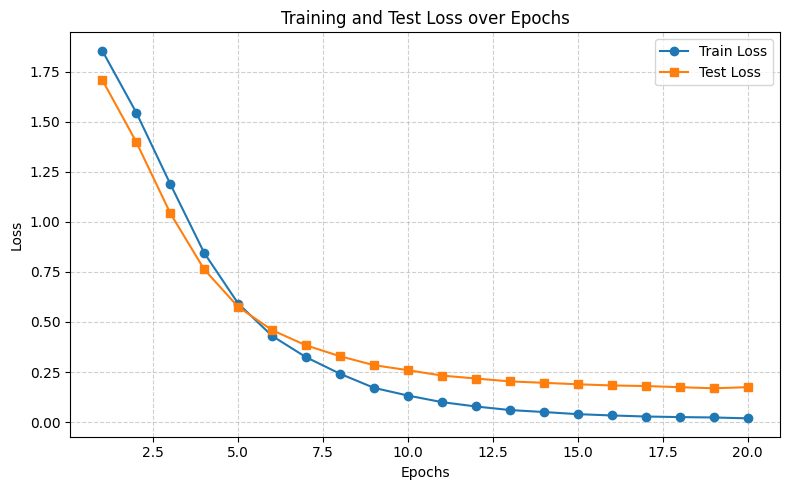

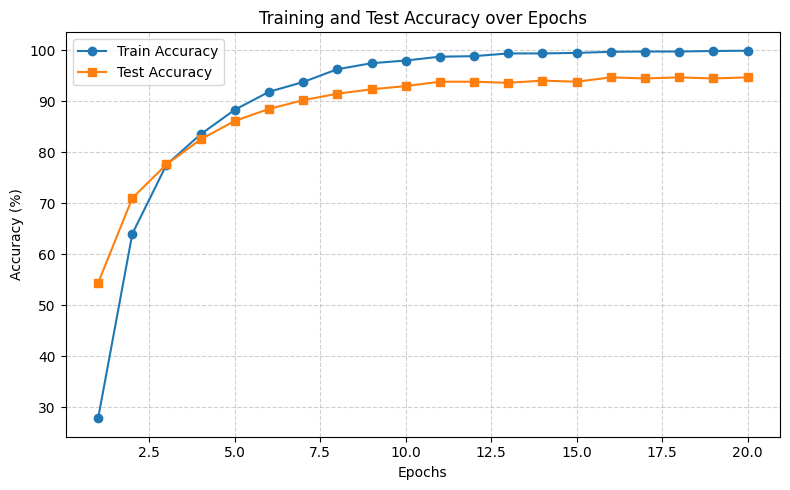

In [5]:
num_epochs = 20

training_log = {
    "train_loss" : [],
    "train_acc" : [],
    "test_loss" : [],
    "test_acc" : []
}

best_test = 0

for epoch in range(num_epochs):

    train_loss, train_acc = train_one_epoch(model, cartoon_train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, cartoon_test_loader, criterion, device)

    training_log["train_loss"].append(train_loss)
    training_log["train_acc"].append(train_acc)
    training_log["test_loss"].append(test_loss)
    training_log["test_acc"].append(test_acc)

    print(f"--------------- Epoch [{epoch+1}/{num_epochs}] ---------------")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.2f}%\n")

    if best_test < test_acc:
        torch.save(model.state_dict(), "/kaggle/working/source_domain_cartoon_weights.pth")
        best_test = test_acc
        print("Best model updated")

plot_training_log(training_log)

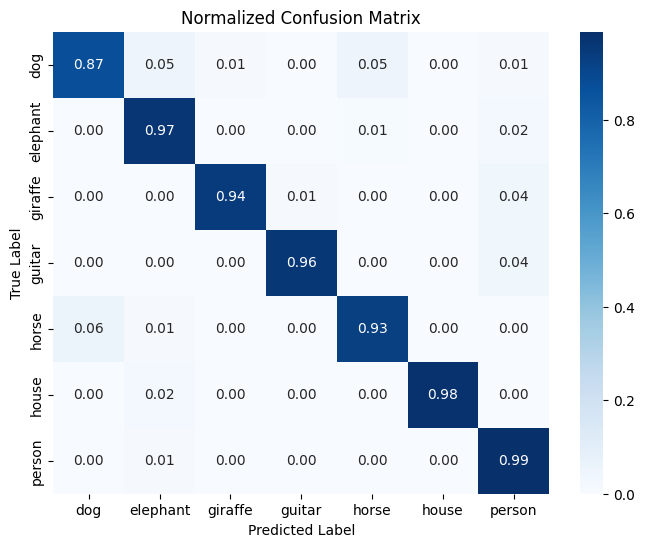

array([[69,  4,  1,  0,  4,  0,  1],
       [ 0, 89,  0,  0,  1,  0,  2],
       [ 0,  0, 68,  1,  0,  0,  3],
       [ 0,  0,  0, 24,  0,  0,  1],
       [ 4,  1,  0,  0, 63,  0,  0],
       [ 0,  1,  0,  0,  0, 47,  0],
       [ 0,  1,  0,  0,  0,  0, 84]])

In [6]:
plot_confusion_matrix(model, cartoon_test_loader)

### Most noticeable confusion is between horse and dog, but that's about the only big one.

### Images it has classified correctly

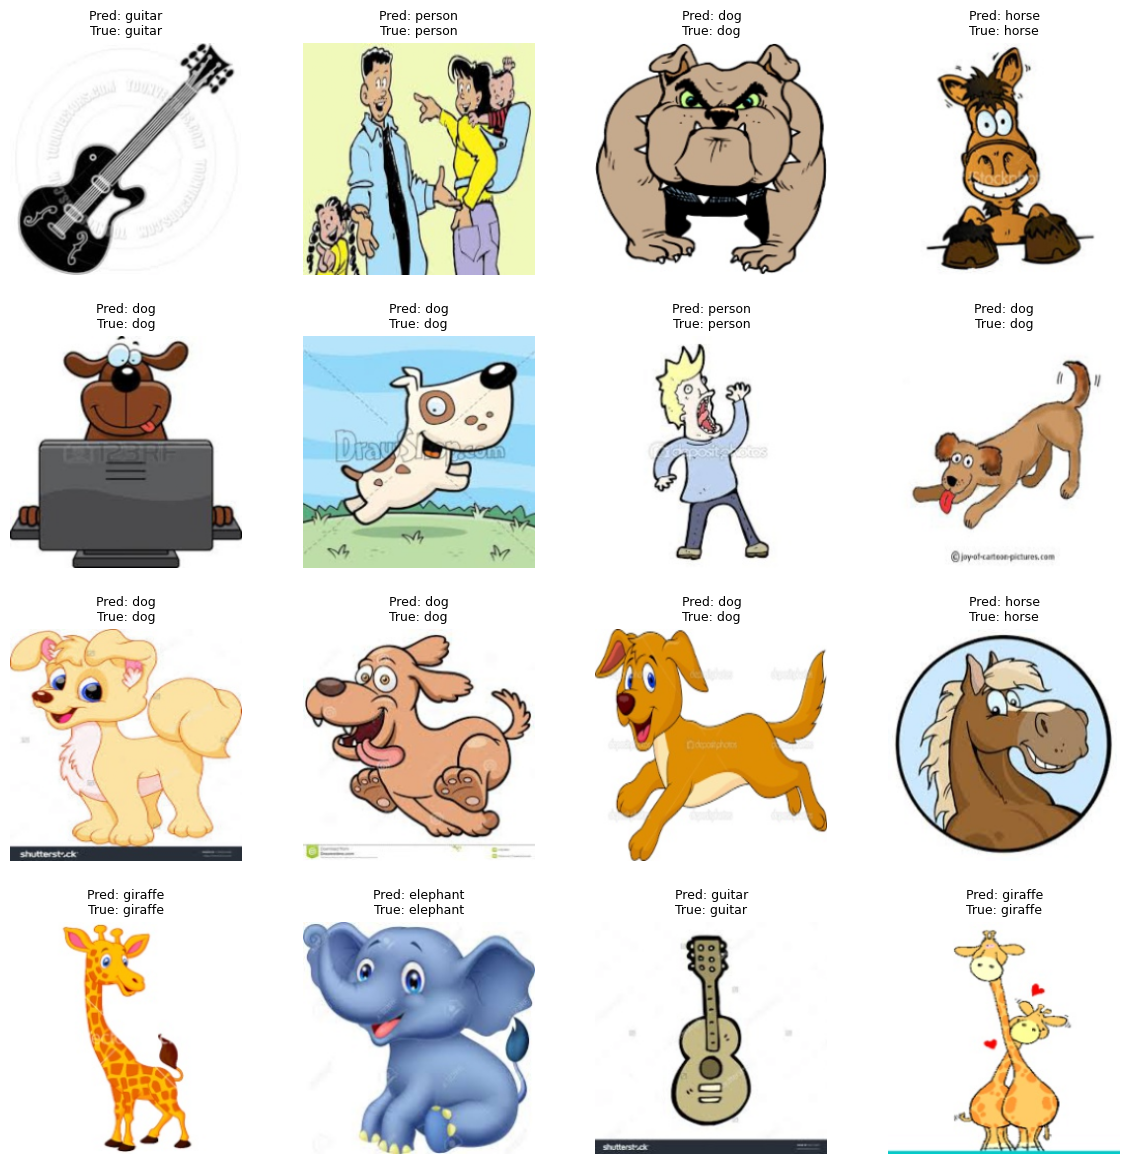

In [7]:
show_preds(model, cartoon_test_loader, show_misclassified=False)

### Images it has classified Incorrectly

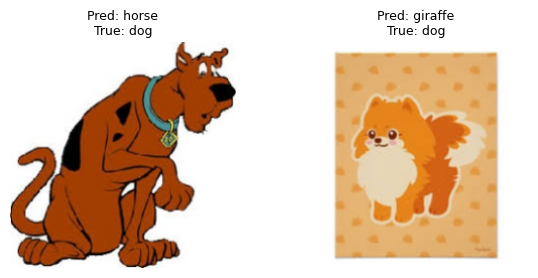

In [8]:
show_preds(model, cartoon_test_loader, show_misclassified=True)

# Now testing on target domain

Target Domain Accuracy: 61.96%


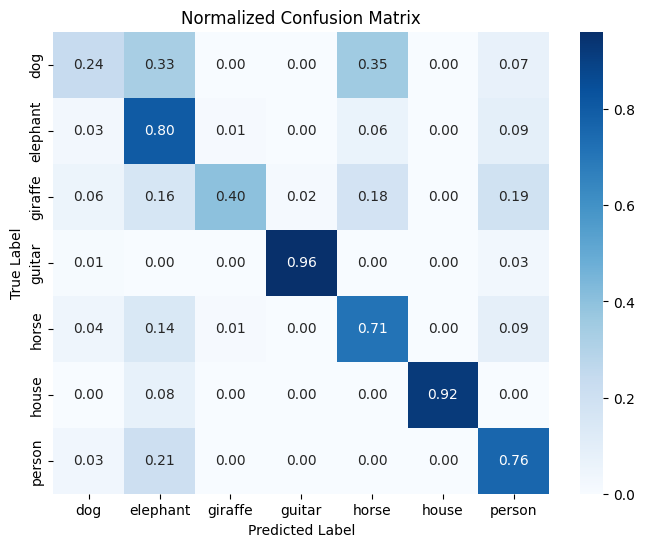

array([[ 36,  50,   0,   0,  53,   0,  11],
       [  4, 114,   2,   0,   9,   0,  13],
       [  9,  26,  65,   3,  29,   0,  31],
       [  1,   0,   0, 124,   0,   0,   4],
       [  7,  23,   2,   0, 114,   0,  14],
       [  0,   1,   0,   0,   0,  12,   0],
       [  1,   6,   0,   0,   0,   0,  22]])

In [9]:
target_test_loss, og_target_test_acc = evaluate(model, sketch_test_loader, criterion, device)
print(f"Target Domain Accuracy: {og_target_test_acc:.2f}%")

plot_confusion_matrix(model, sketch_test_loader)

### images it has correctly classified

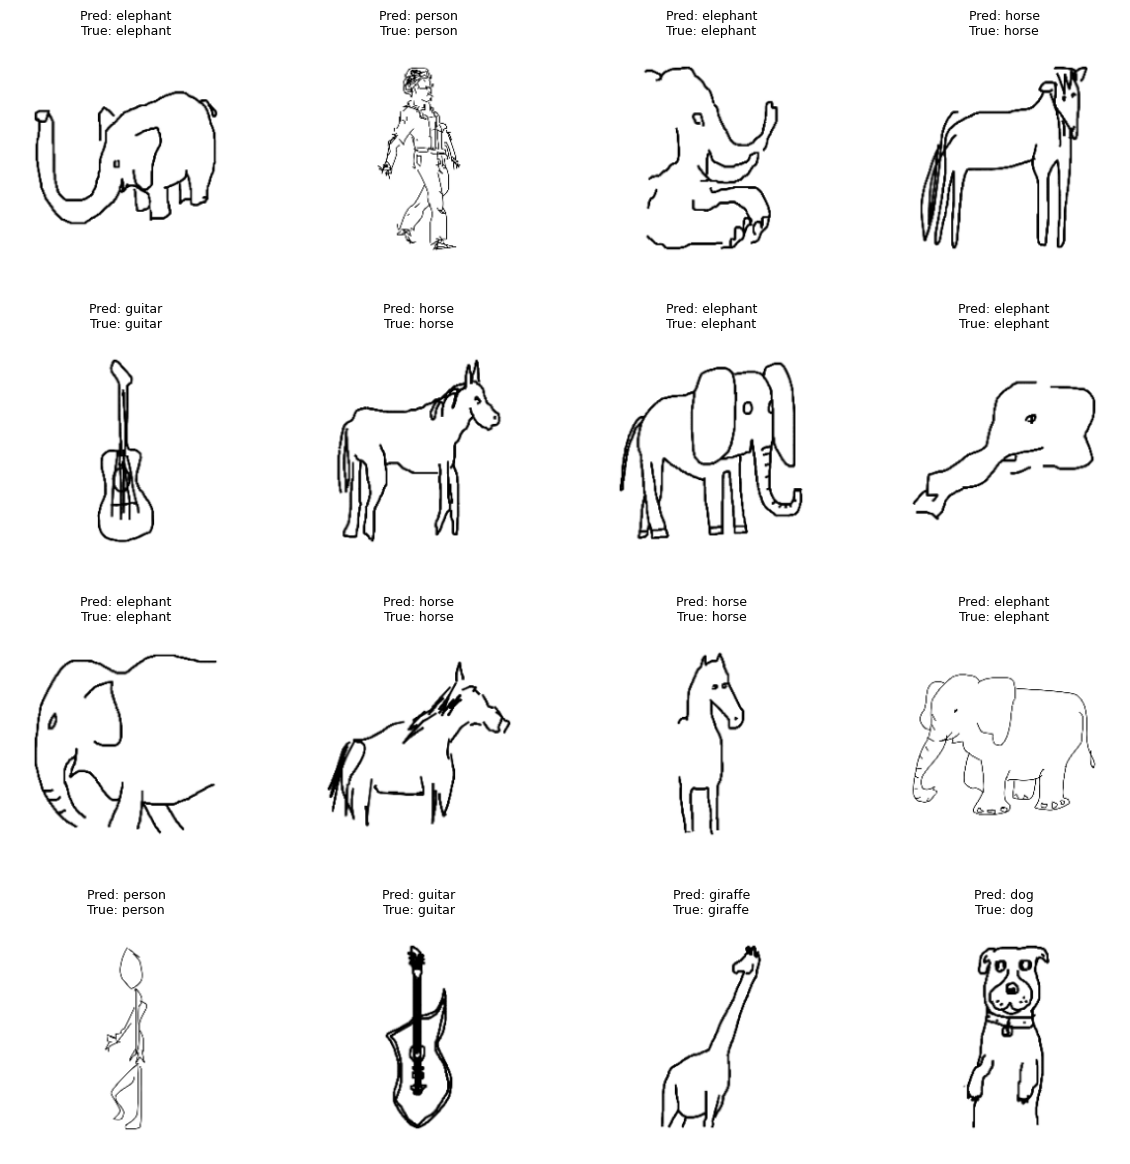

In [10]:
show_preds(model, sketch_test_loader, show_misclassified=False)

### images it has incorrectly classified

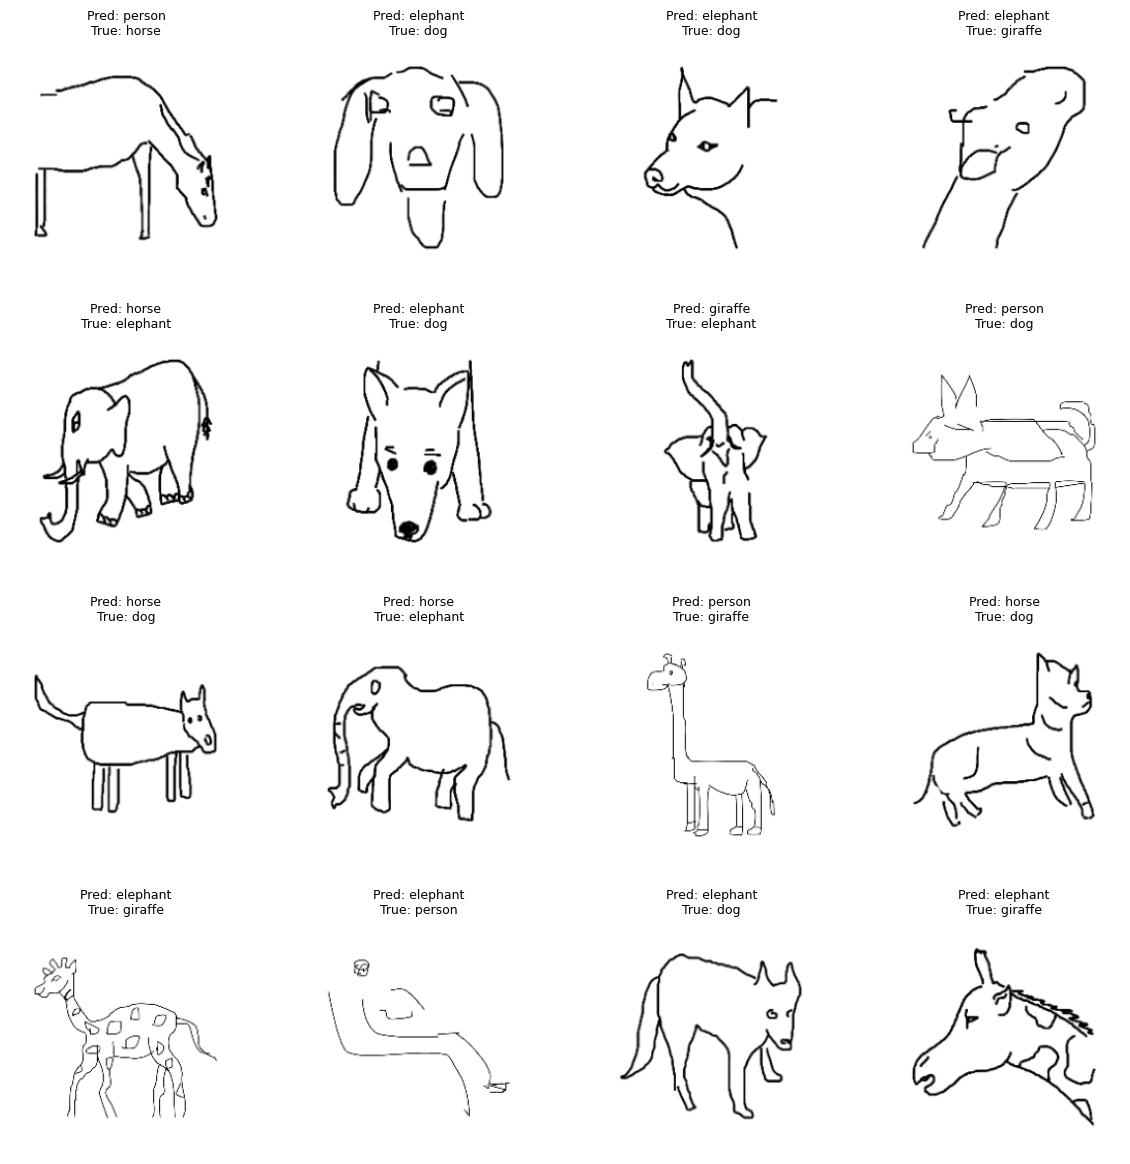

In [11]:
show_preds(model, sketch_test_loader, show_misclassified=True)

# Task 3 - PseudoLabels

### some more utils

In [12]:
def generate_pseudo_labels(model, dataloader, device, threshold=0.9):
    """
    Runs the model on target data and keeps samples with confidence > threshold.
    Returns indices and pseudo-labels.
    """
    model.eval()
    pseudo_labels = []
    indices = []

    with torch.no_grad():
        for batch_idx, (images, _) in enumerate(tqdm(dataloader, desc="Generating pseudo-labels")):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            confs, preds = torch.max(probs, dim=1)

            mask = confs > threshold
            selected = mask.nonzero(as_tuple=True)[0]

            for sel in selected:
                indices.append(batch_idx * dataloader.batch_size + sel.item())
                pseudo_labels.append(preds[sel].cpu().item())

    print(f"✅ Selected {len(indices)} pseudo-labeled samples (threshold={threshold})")
    return indices, pseudo_labels

class PseudoLabeledDataset(Dataset):
    def __init__(self, base_dataset, indices, pseudo_labels):
        self.base = base_dataset
        self.indices = indices
        self.pseudo_labels = pseudo_labels

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        x, _ = self.base[self.indices[idx]]
        y = self.pseudo_labels[idx]
        return x, y

def fine_tune_with_pseudo_labels(model, source_loader, target_loader, criterion, optimizer, num_epochs=5, lr=1e-4, threshold=0.9, lambda_pseudo=0.5):
    """
    Fine-tune a model using source + pseudo-labeled target samples.
    """
    model.to(device)
    criterion = criterion
    optimizer = optimizer
    best_loss = 0

    target_dataset = target_loader.dataset.dataset
    indices, pseudo_labels = generate_pseudo_labels(model, target_loader, device, 0.99)

    pseudo_dataset = PseudoLabeledDataset(target_dataset, indices, pseudo_labels)
    pseudo_loader = DataLoader(pseudo_dataset, batch_size=source_loader.batch_size, shuffle=True, num_workers=2, generator=torch.Generator().manual_seed(SEED))

    for epoch in range(num_epochs):
        print(f"--------------------- Epoch :{epoch+1} --------------------- ")
        lambda_pseudo = min(0.05 + 0.02 * epoch, 0.2)
        model.train()
        running_loss = 0
        total_batches = min(len(source_loader), len(pseudo_loader))
        
        source_loss, source_acc = train_one_epoch(model, cartoon_train_loader, optimizer, criterion, device, pseudo_lambda=1)
        pseudo_loss, pseudo_acc = train_one_epoch(model, pseudo_loader, optimizer, criterion, device, pseudo_lambda=lambda_pseudo)

        print(f"Source - Loss: {source_loss:.2f}, Accuracy: {source_acc:.2f}%")
        print(f"Pseudo - Loss: {pseudo_loss:.2f}, Accuracy: {pseudo_acc:.2f}%")

        target_test_loss, target_test_acc = evaluate(model, sketch_test_loader, criterion, device)
        print(f"Target Domain Accuracy: {target_test_acc:.2f}%")

        if best_loss < target_test_acc:
            best_loss = target_test_acc
            torch.save(model.state_dict(), "/kaggle/working/psuedo.pth")

        if pseudo_acc > 90:
            indices, pseudo_labels = generate_pseudo_labels(model, target_loader, device, 0.999)
            pseudo_dataset = PseudoLabeledDataset(target_dataset, indices, pseudo_labels)
            pseudo_loader = DataLoader(pseudo_dataset, batch_size=source_loader.batch_size, shuffle=True, num_workers=2)
        
    print("🎯 Fine-tuning complete!")
    model.load_state_dict(torch.load("pseudo.pth"))
    return model

def plot_tsne(feature_extractor, source_loader, target_loader, title="", class_names=classes):
    """
    Plots t-SNE of features from a ResNet-50 feature extractor for source and target domains.
    
    Args:
        feature_extractor: ResNet50 with final layer removed or replaced (outputs 2048-dim)
        source_loader: DataLoader for source domain
        target_loader: DataLoader for target domain
        class_names: list of class names corresponding to label indices
        device: 'cuda' or 'cpu'
    """
    feature_extractor.eval()
    feature_extractor.to(device)
    
    all_features = []
    all_labels = []
    all_markers = []  # 0 = source, 1 = target
    
    # Helper to collect features
    def extract_features(dataloader, marker):
        features_list, labels_list = [], []
        markers_list = []
        with torch.no_grad():
            for images, labels in dataloader:
                images = images.to(device)
                features = feature_extractor(images)
                features = features.view(features.size(0), -1)
                features_list.append(features.cpu())
                labels_list.append(labels.cpu())
                markers_list.append(torch.full((labels.size(0),), marker))
        all_features.append(torch.cat(features_list, dim=0))
        all_labels.append(torch.cat(labels_list, dim=0))
        all_markers.append(torch.cat(markers_list, dim=0))

    
    # Extract features from source and target
    extract_features(source_loader, marker=0)
    extract_features(target_loader, marker=1)
    
    all_features = torch.cat(all_features, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    all_markers = torch.cat(all_markers, dim=0).numpy()
    
    # t-SNE to 2D
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(all_features)
    
    # Plot
    plt.figure(figsize=(10,10))
    num_classes = len(class_names)
    cmap = plt.get_cmap('tab10')
    
    markers = ['o', 'x']  # circle for source, x for target
    for idx, class_name in enumerate(class_names):
        for marker_type in [0, 1]:  # source, target
            indices = np.where((all_labels == idx) & (all_markers == marker_type))
            plt.scatter(features_2d[indices, 0], features_2d[indices, 1],
                        label=f"{class_name} {'source' if marker_type==0 else 'target'}",
                        alpha=0.7, color=cmap(idx % 10), marker=markers[marker_type])
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

# Actually training the model now using pseudo labels

In [13]:
new_backbone, new_classifier = get_model()
adapt_model = nn.Sequential(new_backbone, new_classifier)
adapt_model.load_state_dict(torch.load("/kaggle/working/source_domain_cartoon_weights.pth"))
adapt_model = adapt_model.to(device)

adapt_criterion=nn.CrossEntropyLoss()
adapt_optimizer = optim.Adam([
    {'params': new_backbone.parameters(), 'lr': 1e-5},
    {'params': new_classifier.parameters(), 'lr': 5e-5}
], weight_decay=1e-4)

adapt_model = fine_tune_with_pseudo_labels(
    model=adapt_model,
    source_loader=cartoon_train_loader,
    target_loader=sketch_train_loader,
    criterion=adapt_criterion,
    optimizer=adapt_optimizer,
    num_epochs=20,
    threshold=0.95,
    lambda_pseudo=0.2
)

target_test_loss, target_test_acc = evaluate(adapt_model, sketch_test_loader, criterion, device)
print(f"Target Domain Accuracy: {target_test_acc:.2f}%, from originally {og_target_test_acc:.2f}%")

Generating pseudo-labels: 100%|██████████| 50/50 [00:10<00:00,  4.67it/s]


✅ Selected 36 pseudo-labeled samples (threshold=0.99)
--------------------- Epoch :1 --------------------- 


Training: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Source - Loss: 0.03, Accuracy: 99.63%
Pseudo - Loss: 0.16, Accuracy: 22.22%


Target Domain Accuracy: 63.23%
--------------------- Epoch :2 --------------------- 


Training: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Source - Loss: 0.02, Accuracy: 99.68%
Pseudo - Loss: 0.18, Accuracy: 25.00%


Target Domain Accuracy: 62.98%
--------------------- Epoch :3 --------------------- 


Training: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Source - Loss: 0.02, Accuracy: 99.89%
Pseudo - Loss: 0.18, Accuracy: 36.11%


Target Domain Accuracy: 64.12%
--------------------- Epoch :4 --------------------- 


Training: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Source - Loss: 0.01, Accuracy: 99.89%
Pseudo - Loss: 0.17, Accuracy: 61.11%


Target Domain Accuracy: 64.12%
--------------------- Epoch :5 --------------------- 


Training: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Source - Loss: 0.01, Accuracy: 99.95%
Pseudo - Loss: 0.15, Accuracy: 66.67%


Target Domain Accuracy: 64.89%
--------------------- Epoch :6 --------------------- 


Training: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Source - Loss: 0.01, Accuracy: 99.89%
Pseudo - Loss: 0.15, Accuracy: 72.22%


Target Domain Accuracy: 63.61%
--------------------- Epoch :7 --------------------- 


Training: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Source - Loss: 0.01, Accuracy: 99.95%
Pseudo - Loss: 0.12, Accuracy: 77.78%


Target Domain Accuracy: 64.50%
--------------------- Epoch :8 --------------------- 


Training: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Source - Loss: 0.01, Accuracy: 100.00%
Pseudo - Loss: 0.09, Accuracy: 91.67%


Target Domain Accuracy: 66.41%


Generating pseudo-labels: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s]


✅ Selected 20 pseudo-labeled samples (threshold=0.999)
--------------------- Epoch :9 --------------------- 


Training: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Source - Loss: 0.01, Accuracy: 99.89%
Pseudo - Loss: 0.52, Accuracy: 35.00%


Target Domain Accuracy: 66.03%
--------------------- Epoch :10 --------------------- 


Training: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Source - Loss: 0.00, Accuracy: 100.00%
Pseudo - Loss: 0.26, Accuracy: 60.00%


Target Domain Accuracy: 64.89%
--------------------- Epoch :11 --------------------- 


Training: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Source - Loss: 0.01, Accuracy: 100.00%
Pseudo - Loss: 0.15, Accuracy: 80.00%


Target Domain Accuracy: 66.03%
--------------------- Epoch :12 --------------------- 


Training: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Source - Loss: 0.00, Accuracy: 100.00%
Pseudo - Loss: 0.10, Accuracy: 90.00%


Target Domain Accuracy: 66.03%
--------------------- Epoch :13 --------------------- 


Training: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Source - Loss: 0.00, Accuracy: 100.00%
Pseudo - Loss: 0.07, Accuracy: 100.00%


Target Domain Accuracy: 65.01%


Generating pseudo-labels: 100%|██████████| 50/50 [00:07<00:00,  6.59it/s]


✅ Selected 36 pseudo-labeled samples (threshold=0.999)
--------------------- Epoch :14 --------------------- 


Training: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Source - Loss: 0.00, Accuracy: 100.00%
Pseudo - Loss: 0.55, Accuracy: 27.78%


Target Domain Accuracy: 66.92%
--------------------- Epoch :15 --------------------- 


Training: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Source - Loss: 0.00, Accuracy: 100.00%
Pseudo - Loss: 0.22, Accuracy: 66.67%


Target Domain Accuracy: 65.90%
--------------------- Epoch :16 --------------------- 


Training: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Source - Loss: 0.01, Accuracy: 99.84%
Pseudo - Loss: 0.11, Accuracy: 86.11%


Target Domain Accuracy: 65.90%
--------------------- Epoch :17 --------------------- 


Training: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Source - Loss: 0.00, Accuracy: 100.00%
Pseudo - Loss: 0.08, Accuracy: 88.89%


Target Domain Accuracy: 64.50%
--------------------- Epoch :18 --------------------- 


Training: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Source - Loss: 0.00, Accuracy: 100.00%
Pseudo - Loss: 0.06, Accuracy: 94.44%


Target Domain Accuracy: 64.63%


Generating pseudo-labels: 100%|██████████| 50/50 [00:07<00:00,  6.57it/s]


✅ Selected 52 pseudo-labeled samples (threshold=0.999)
--------------------- Epoch :19 --------------------- 


Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Source - Loss: 0.00, Accuracy: 100.00%
Pseudo - Loss: 0.40, Accuracy: 34.62%


Target Domain Accuracy: 65.14%
--------------------- Epoch :20 --------------------- 


Training: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Source - Loss: 0.00, Accuracy: 100.00%
Pseudo - Loss: 0.16, Accuracy: 63.46%


Target Domain Accuracy: 64.50%
🎯 Fine-tuning complete!


FileNotFoundError: [Errno 2] No such file or directory: 'pseudo.pth'

In [15]:
adapt_model.load_state_dict(torch.load("/kaggle/working/psuedo.pth"))

<All keys matched successfully>

Source Domain Accuracy: 94.46%, from originally 94.67%


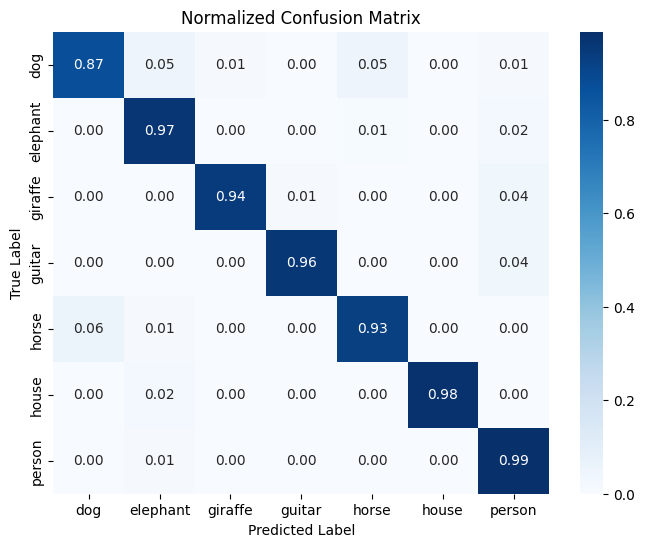

array([[69,  4,  1,  0,  4,  0,  1],
       [ 0, 89,  0,  0,  1,  0,  2],
       [ 0,  0, 68,  1,  0,  0,  3],
       [ 0,  0,  0, 24,  0,  0,  1],
       [ 4,  1,  0,  0, 63,  0,  0],
       [ 0,  1,  0,  0,  0, 47,  0],
       [ 0,  1,  0,  0,  0,  0, 84]])

In [16]:
source_test_loss, source_test_acc = evaluate(adapt_model, cartoon_test_loader, criterion, device)
print(f"Source Domain Accuracy: {source_test_acc:.2f}%, from originally {best_test:.2f}%")

plot_confusion_matrix(model, cartoon_test_loader)

Target Domain Accuracy: 66.92%, from originally 61.96%


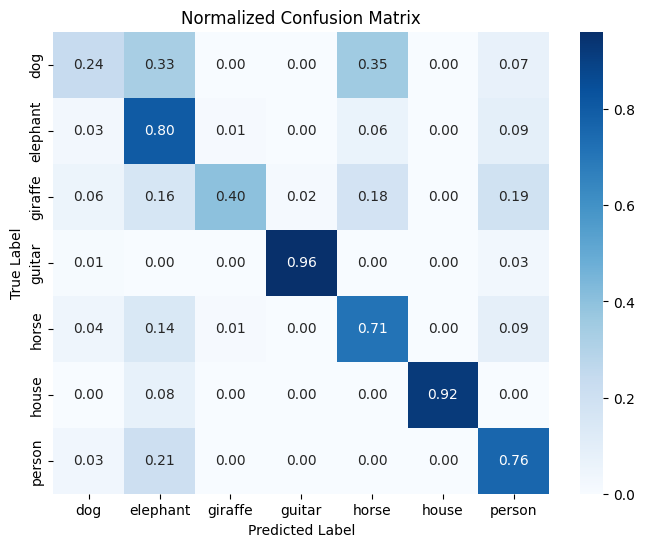

array([[ 36,  50,   0,   0,  53,   0,  11],
       [  4, 114,   2,   0,   9,   0,  13],
       [  9,  26,  65,   3,  29,   0,  31],
       [  1,   0,   0, 124,   0,   0,   4],
       [  7,  23,   2,   0, 114,   0,  14],
       [  0,   1,   0,   0,   0,  12,   0],
       [  1,   6,   0,   0,   0,   0,  22]])

In [17]:
target_test_loss, target_test_acc = evaluate(adapt_model, sketch_test_loader, criterion, device)
print(f"Target Domain Accuracy: {target_test_acc:.2f}%, from originally {og_target_test_acc:.2f}%")

plot_confusion_matrix(model, sketch_test_loader)

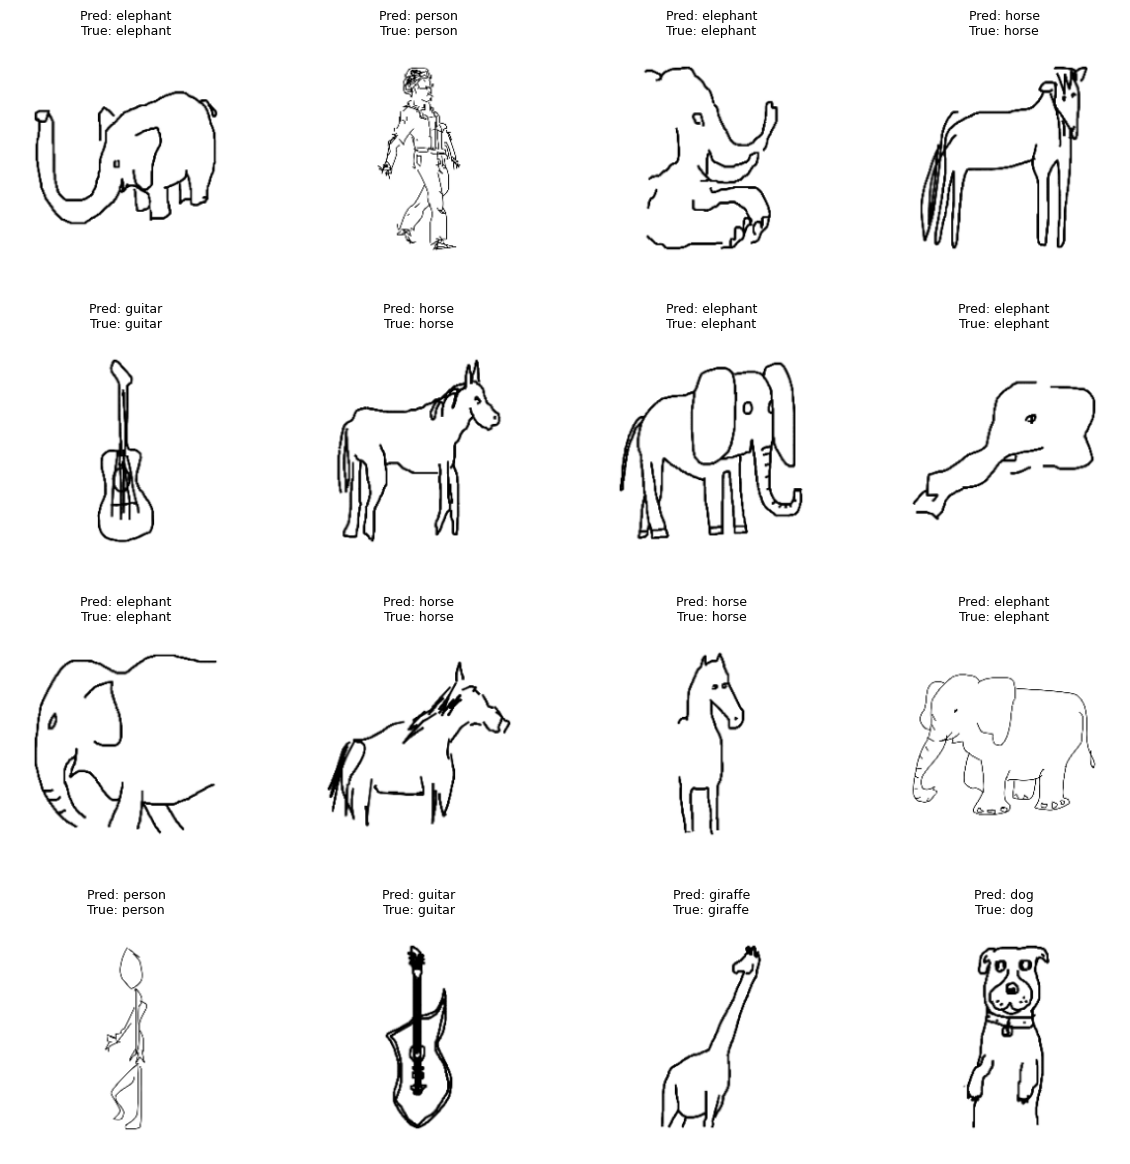

In [18]:
show_preds(model, sketch_test_loader, show_misclassified=False)

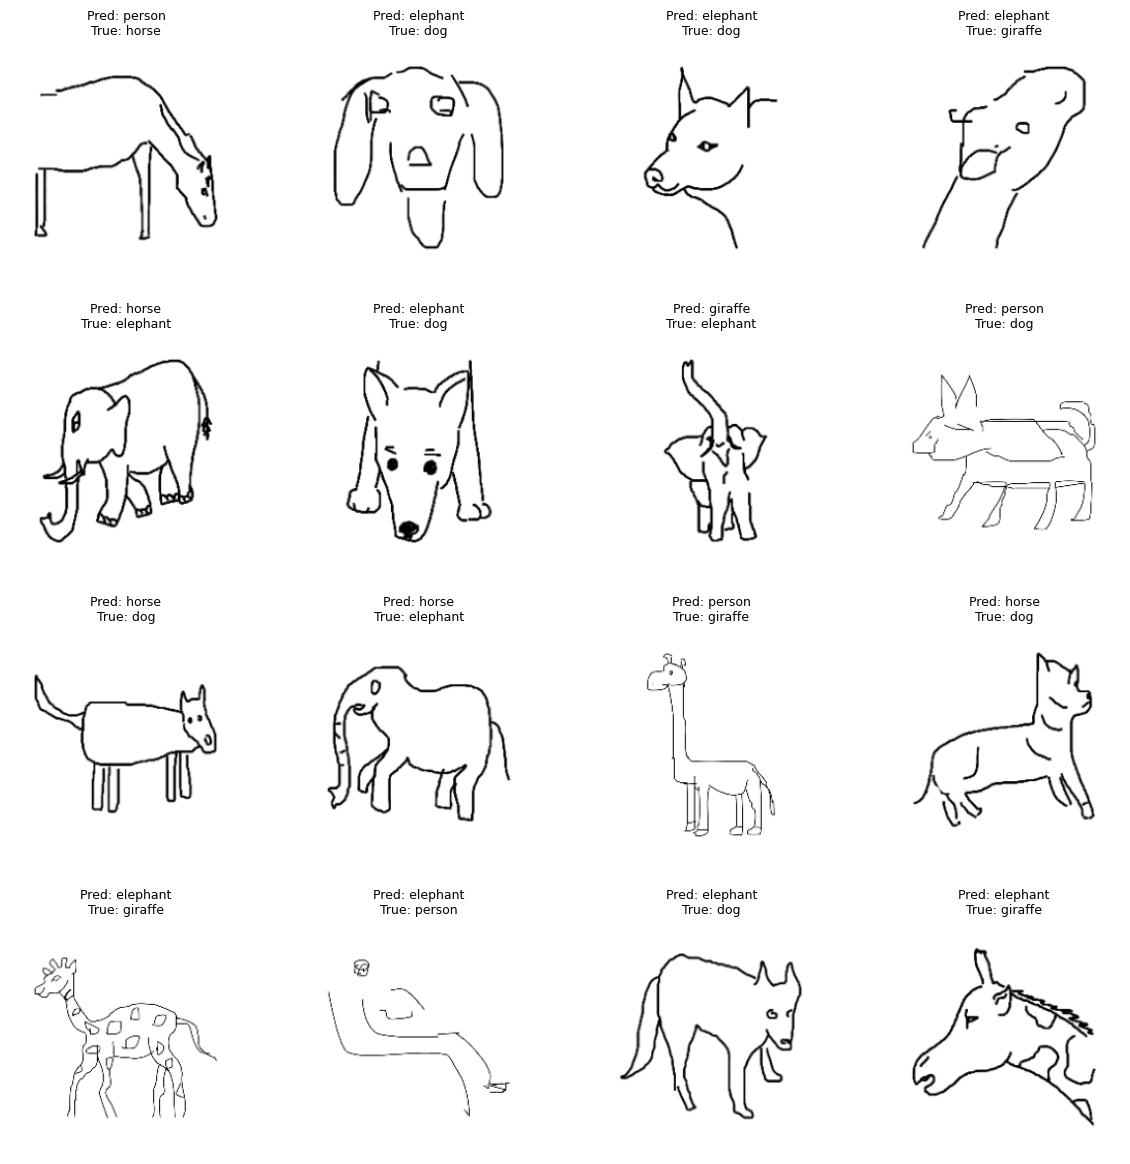

In [19]:
show_preds(model, sketch_test_loader, show_misclassified=True)

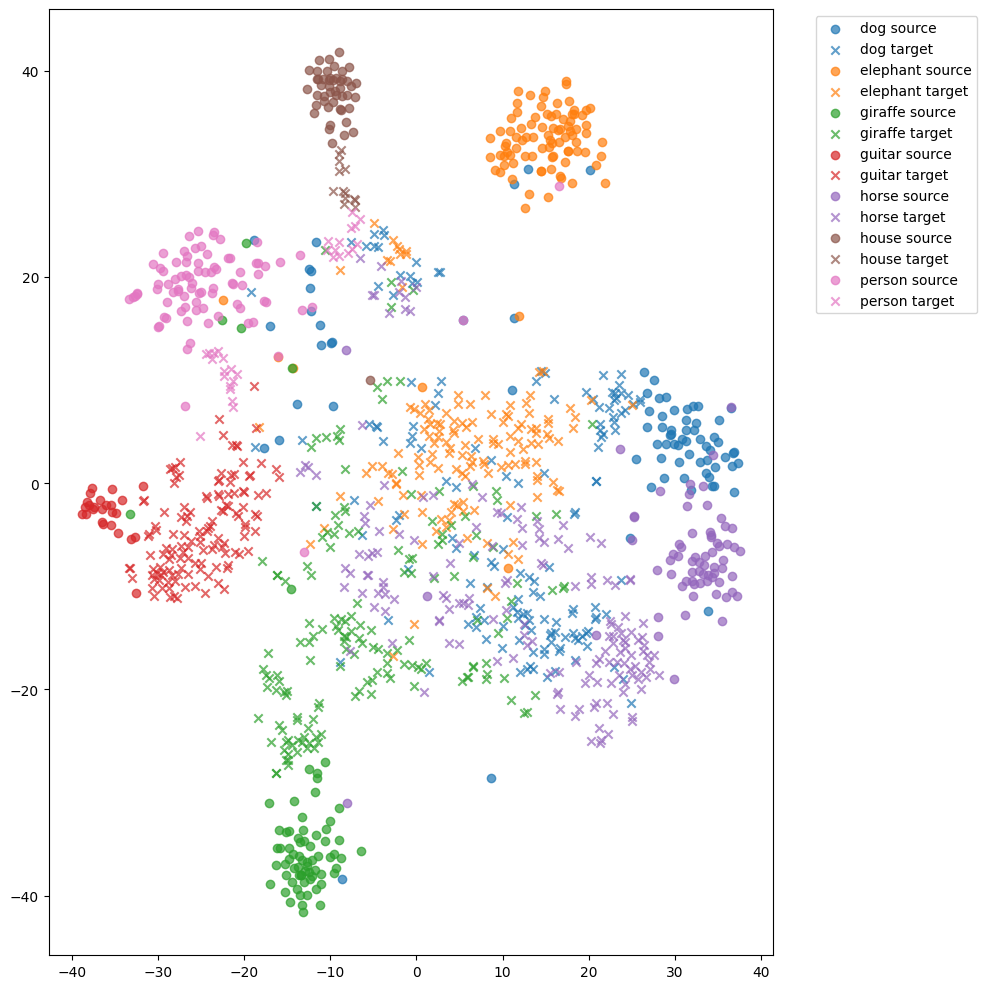

In [20]:
plot_tsne(backbone, cartoon_test_loader, sketch_test_loader, class_names=classes)

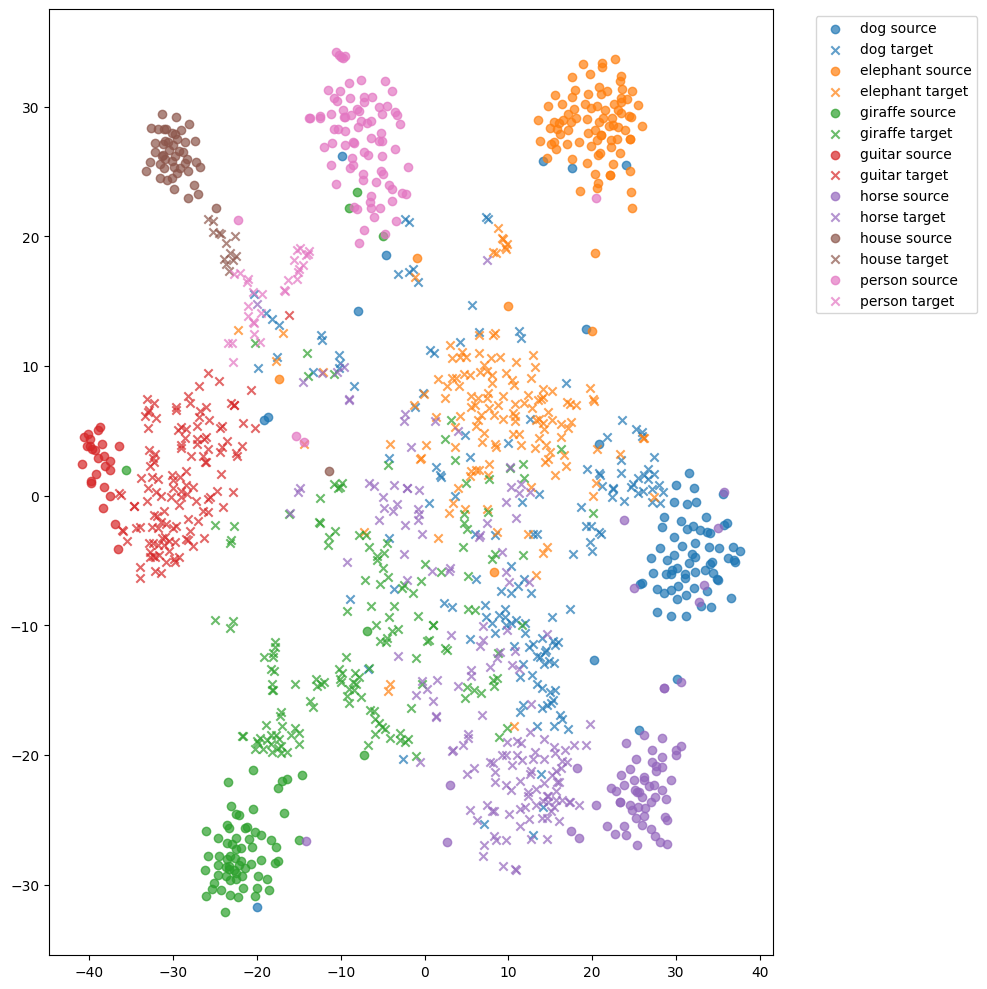

In [21]:
plot_tsne(new_backbone, cartoon_test_loader, sketch_test_loader, class_names=classes)